## Multilabel with Segmentation U-Net, FCN & Mask RCNN

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras as K
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing import image
from keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Define utilites

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

,Filename,Label
0,image_1.jpg,"[Kerbau,Manusia]"
1,image_10.jpg,"[Kerbau,Manusia]"
2,image_100.jpg,[Kerbau]
3,image_101.jpg,"[Kerbau,Manusia]"
4,image_102.jpg,"[Kerbau,Manusia]"
...,...,...
2110,image_1999.jpg,"[Kerbau,Manusia,Truk]"
2111,image_2.jpg,"[Kerbau,Manusia]"
2112,image_20.jpg,"[Kerbau,Manusia]"
2113,image_200.jpg,[Kerbau]


In [3]:
# buat daftar unique dari semua label
unique_label = set()
for label in df["Label"]:
    label_list = label.strip("[]").split(",")
    for label in label_list:
        unique_label.add(label.strip())
        
# buatkan kolom one-hot encodinf setiap label
for label in unique_label:
    df[label] = df["Label"].apply(lambda x: int(label in x))

In [4]:
df.head()

,Filename,Label,Truk,Kerbau,Motor,Hewan liar,Manusia
0,image_1.jpg,"[Kerbau,Manusia]",0,1,0,0,1
1,image_10.jpg,"[Kerbau,Manusia]",0,1,0,0,1
2,image_100.jpg,[Kerbau],0,1,0,0,0
3,image_101.jpg,"[Kerbau,Manusia]",0,1,0,0,1
4,image_102.jpg,"[Kerbau,Manusia]",0,1,0,0,1


<Axes: xlabel='Label'>

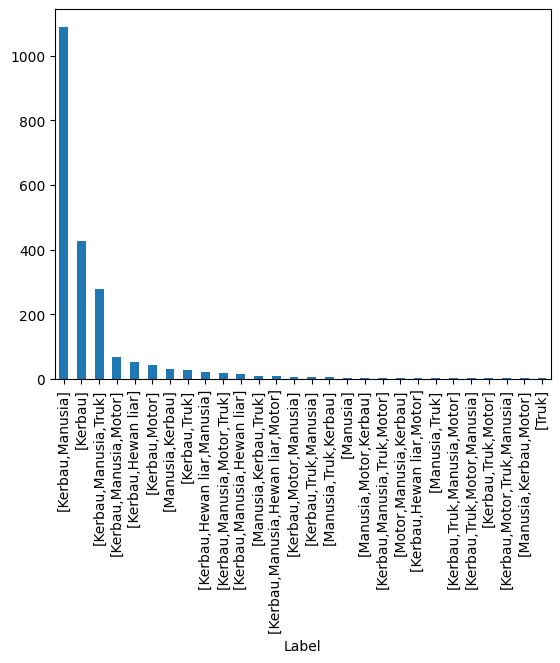

In [5]:
df['Label'].value_counts().plot(kind='bar')

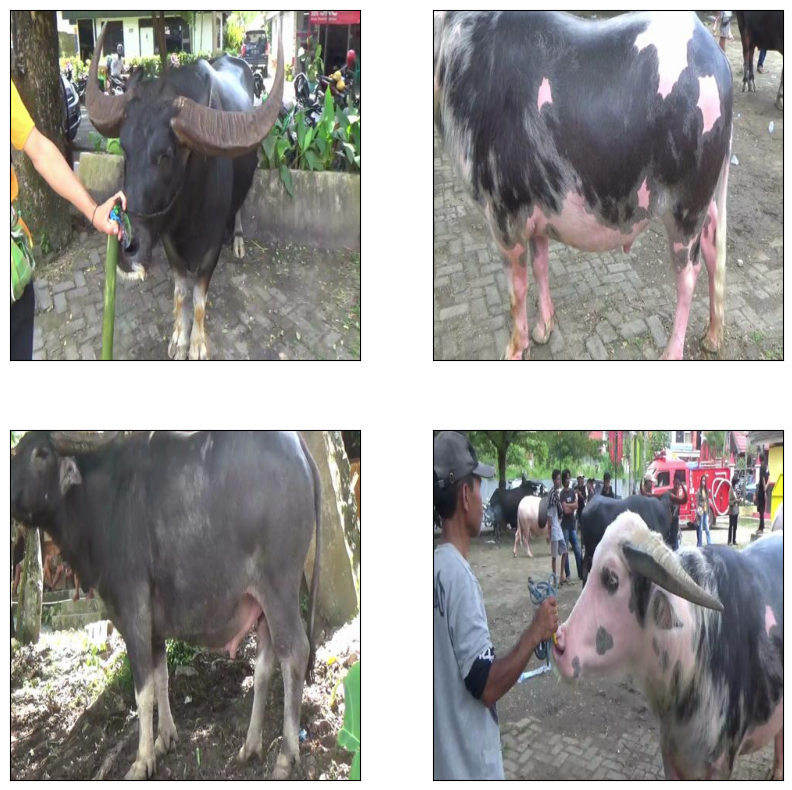

In [6]:
random_index = np.random.randint(0, len(df), 10)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread("data/image/"+ df.Filename[random_index[i]]))
plt.show()

In [ ]:
# X_dataset = []
# for i in tqdm(range(df.shape[0])):
#     img = image.load_img('data/image/' + df["Filename"][i], target_size=(448, 448, 3))
#     img = image.img_to_array(img)
#     img /= 255.0
#     X_dataset.append(img)

In [ ]:
# X = np.array(X_dataset)

In [ ]:
# y = np.array(df.drop(columns=["Filename","Label"], axis=1))
# y

In [7]:
df["Filename"] = 'data/image/' + df["Filename"]
df.drop(columns='Label', axis=1, inplace=True)
df

,Filename,Truk,Kerbau,Motor,Hewan liar,Manusia
0,data/image/image_1.jpg,0,1,0,0,1
1,data/image/image_10.jpg,0,1,0,0,1
2,data/image/image_100.jpg,0,1,0,0,0
3,data/image/image_101.jpg,0,1,0,0,1
4,data/image/image_102.jpg,0,1,0,0,1
...,...,...,...,...,...,...
2110,data/image/image_1999.jpg,1,1,0,0,1
2111,data/image/image_2.jpg,0,1,0,0,1
2112,data/image/image_20.jpg,0,1,0,0,1
2113,data/image/image_200.jpg,0,1,0,0,0


In [8]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
train

,Filename,Truk,Kerbau,Motor,Hewan liar,Manusia
2072,data/image/image_1964.jpg,0,1,0,0,1
1549,data/image/image_1490.jpg,0,1,1,0,1
73,data/image/image_165.jpg,0,1,0,0,0
596,data/image/image_587.jpg,0,1,0,0,1
1107,data/image/image_1092.jpg,1,1,0,0,1
...,...,...,...,...,...,...
1638,data/image/image_1570.jpg,0,1,1,0,1
1095,data/image/image_1081.jpg,1,1,0,0,1
1130,data/image/image_1112.jpg,0,1,0,0,1
1294,data/image/image_1260.jpg,1,1,0,0,1


In [10]:
columns = ["Truk"	,"Kerbau",	"Motor",	"Hewan liar",	"Manusia"]

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
train_gen = train_datagen.flow_from_dataframe(train, 
                                              x_col='Filename', 
                                              y_col=columns,
                                              target_size=(224,224),
                                              class_mode='raw',
                                              batch_size=32,
                                              shuffle=True,
                                              subset='training')
val_gen = train_datagen.flow_from_dataframe(train,
                                          x_col='Filename',
                                          y_col=columns,
                                          target_size=(224,224),
                                          class_mode='raw',
                                          batch_size=16,
                                          subset='validation')
test_gen = test_datagen.flow_from_dataframe(test,
                                            x_col='Filename',
                                            y_col=columns,
                                            target_size=(224,224),
                                            class_mode='raw')

Found 1354 validated image filenames.
Found 338 validated image filenames.
Found 423 validated image filenames.


# Metrci Evaluations

# Define Loss

# U-Net

Berikut arsitektur keseluruhan U-Net yang akan digunakan:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

UNet terdiri dari encoder (downsampler) dan decoder (upsampler) dengan hambatan di antaranya. Panah abu-abu sesuai dengan koneksi lompatan yang menggabungkan output blok encoder ke setiap tahap decoder.

### Encoder
Block-block encoder berisi 2 layer Conv2D diakttifkan oleh relu, serta di ikuti oleh MaxpPooling dan Dropout

In [14]:
def conv2d_block(input_tensor, n_filter, kernel_size=3):
    ''' 
    Arg:
    input_tensor (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    kernel_size (int) -- ukuran kernel untuk konvolusi

    return
    tensor dari fitur keluaran
    '''
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=(kernel_size, kernel_size),\
                                    kernel_initializer="he_normal",padding='same')(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filter=64, pool_size=2, dropout=0.3):
    '''
    Arg:
    input (tensor) - tensor masukan
    n_filter (int) - jumlah filter
    pool_size - ukuran pool size
    dropout - jumlah yang ingin di dropout/buang

    return
    f - fitur keluaran dari block conv
    p - fitur yang dikumpulkan di MaxPooling dengan DropOut
    '''
    f = conv2d_block(inputs, n_filter=n_filter)
    p = tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size))(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

def encoder(inputs):
    '''
    Arg:
    inputs - masukkan gambar

    return
    p4 - fitur yang dikumpulkan dari keseluruhan encoder block
    (f1, f2, f3, f4) - fitur yang dikeluarkan dari semua encoder block
    '''
    f1, p1 = encoder_block(inputs, n_filter=64, pool_size=2, dropout=0.3)
    f2, p2 = encoder_block(p1, n_filter=128, pool_size=2, dropout=0.3)
    f3, p3 = encoder_block(p2, n_filter=256, pool_size=2, dropout=0.3)
    f4, p4 = encoder_block(p3, n_filter=512, pool_size=2, dropout=0.3)
    return p4, (f1, f2, f3, f4)


### Bottleneck
Sebuah bottleneck mengikuti blok encoder dan digunakan untuk mengekstrak lebih banyak fitur. Ini tidak memiliki lapisan penyatuan sehingga dimensinya tetap sama.

In [15]:
def bottleneck(inputs):

    x = conv2d_block(inputs, n_filter=1024)
    return x

### Decoder
 decoder yang meng-upsampling fitur kembali ke ukuran gambar asli. Pada setiap tingkat upsampling, akan mengambil output dari blok encoder yang sesuai dan menggabungkannya sebelum memasukkannya ke blok decoder berikutnya

In [16]:
def decoder_block(inputs, conv_output, n_filter=64, kernel_size=3, strides=2, dropout=0.3):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    conv_output (tensor) - fitur dari blok encoder
    n_filter (int) -- jumlah filter
    kernel_size (int) -- ukuran kernel
    strides (int) -- langkah untuk dekonvolusi/upsampling
    padding (string) - "sama" atau "valid", memberi tahu apakah bentuk akan dipertahankan dengan padding nol

    return
    c (tensor) - fitur keluaran dari blok decoder
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filter, kernel_size=3)

    return c

def decoder(input, convs, output_channels):
    '''
    Arg:
    inputs (tensor) - kumpulan fitur input
    convs (tuple) -- fitur dari blok penyandi
    output_channels (int) -- jumlah kelas dalam peta label
    activation (softmax/sigmoid,etc) - aktifasi yang dipakai

    return
    output (tensor) -- peta label berdasarkan piksel dari gambar
    '''
    f1, f2, f3, f4 = convs

    c6 = decoder_block(input, f4, n_filter=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filter=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filter=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filter=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    flatten = tf.keras.layers.Flatten()(c9)
    output =  tf.keras.layers.Dense(output_channels, activation='sigmoid')(flatten)
    return output


In [17]:
def unet(input_shape):
    '''
    Mendefinisikan UNet dengan menghubungkan encoder, bottleneck, dan decoder.

    args:
    input_shape (int)- besaran deminsi input
    output (int) - jumlah output yang dikeluarkna
    activation - aktifasi yang digunakan untuk klasifikasi
    '''

    input = tf.keras.layers.Input(shape=input_shape)
    encoder_output, convs = encoder(input)
    bottlenecks = bottleneck(encoder_output)
    outputs = decoder(bottlenecks, convs, output_channels=5)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    return model

In [18]:
auc = tf.keras.metrics.AUC(multi_label=True,thresholds=[0,0.5])
aucpr = tf.keras.metrics.AUC(curve='PR',multi_label=True,thresholds=[0,0.5])
model_uNet = unet(input_shape=(224, 224, 3,))
model_uNet.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=["accuracy", auc, aucpr])

In [19]:
model_uNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 224, 224, 64  0           ['conv2d_18[0][0]']              
                                )                                                           

In [23]:
%load_ext tensorboard

In [24]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs", datetime.datetime.now().strftime(f"%Y-%m-%d-{name}"))
    return TensorBoard(logdir)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.9):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.accuracy:
            print(f"\nAkurasi telah mencapai {self.accuracy}%")
            self.model.stop_training = True

In [25]:
with tf.device("/device:GPU:0"):
    history1 = model_uNet.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("uNet"),
                              myCallback(accuracy=0.9)])

Epoch 1/50
42/42 [==============================] - 50s 642ms/step - loss: 96.7521 - accuracy: 0.7753 - auc: 0.4902 - auc_1: 0.4022 - val_loss: 0.3343 - val_accuracy: 0.8274 - val_auc: 0.5000 - val_auc_1: 0.4089
Epoch 2/50
42/42 [==============================] - 17s 402ms/step - loss: 0.2736 - accuracy: 0.8396 - auc: 0.4999 - auc_1: 0.4025 - val_loss: 0.3065 - val_accuracy: 0.8274 - val_auc: 0.5000 - val_auc_1: 0.4083
Epoch 3/50
42/42 [==============================] - 17s 402ms/step - loss: 0.2456 - accuracy: 0.8419 - auc: 0.5126 - auc_1: 0.4061 - val_loss: 0.3138 - val_accuracy: 0.8274 - val_auc: 0.5257 - val_auc_1: 0.4399
Epoch 4/50
42/42 [==============================] - 17s 404ms/step - loss: 0.2029 - accuracy: 0.8389 - auc: 0.5520 - auc_1: 0.4544 - val_loss: 0.2735 - val_accuracy: 0.8274 - val_auc: 0.5862 - val_auc_1: 0.4767
Epoch 5/50
42/42 [==============================] - 17s 410ms/step - loss: 0.1304 - accuracy: 0.8404 - auc: 0.7310 - auc_1: 0.7185 - val_loss: 0.2874 - val

In [31]:
model_uNet.evaluate(test_gen)

14/14 [==============================] - 3s 213ms/step - loss: 0.6666 - accuracy: 0.8109 - auc: 0.6152 - auc_1: 0.5531


[0.6666241884231567,
 0.8108747005462646,
 0.6151612401008606,
 0.5531474351882935]

In [28]:
def model_common():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    x = conv2d_block(input_tensor=inputs, n_filter=64)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=128)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=128)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=256)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = conv2d_block(input_tensor=x, n_filter=512)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [33]:
model_common.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_64 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 activation_28 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_65 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 activation_29 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                           

In [29]:
model_common = model_common()
model_common.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=["accuracy", auc, aucpr])

In [30]:
 history2 = model_common.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("common"),
                              myCallback(accuracy=0.9)])

Epoch 1/50
42/42 [==============================] - 8s 128ms/step - loss: 0.4559 - accuracy: 0.8230 - auc: 0.5152 - auc_1: 0.4144 - val_loss: 0.3230 - val_accuracy: 0.8274 - val_auc: 0.5000 - val_auc_1: 0.4083
Epoch 2/50
42/42 [==============================] - 4s 105ms/step - loss: 0.2938 - accuracy: 0.8389 - auc: 0.5022 - auc_1: 0.4028 - val_loss: 0.3012 - val_accuracy: 0.8274 - val_auc: 0.5049 - val_auc_1: 0.4109
Epoch 3/50
42/42 [==============================] - 4s 105ms/step - loss: 0.2672 - accuracy: 0.8374 - auc: 0.5120 - auc_1: 0.4103 - val_loss: 0.2933 - val_accuracy: 0.8274 - val_auc: 0.5506 - val_auc_1: 0.4408
Epoch 4/50
42/42 [==============================] - 4s 105ms/step - loss: 0.2547 - accuracy: 0.8419 - auc: 0.5367 - auc_1: 0.4348 - val_loss: 0.2821 - val_accuracy: 0.8274 - val_auc: 0.5295 - val_auc_1: 0.4288
Epoch 5/50
42/42 [==============================] - 4s 104ms/step - loss: 0.2377 - accuracy: 0.8419 - auc: 0.5447 - auc_1: 0.4337 - val_loss: 0.2721 - val_accur

In [32]:
model_common.evaluate(test_gen)

14/14 [==============================] - 1s 54ms/step - loss: 0.4244 - accuracy: 0.8652 - auc: 0.7928 - auc_1: 0.8232


[0.42443156242370605,
 0.8652482032775879,
 0.7927684783935547,
 0.8231742978096008]